In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

# numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

df_reg = df.drop(categorical_attr_list, axis=1)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))
df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
2,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
3,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,172972,0.140289,8.110521e-07,0.003085,-0.032349,0.028961,-0.008942,-0.004242,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

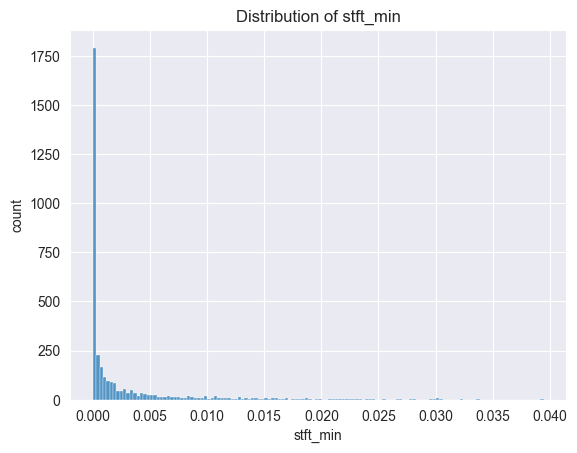

In [5]:
sns.histplot(data=df, x=df['stft_min'], stat='density')
plt.xlabel(f'stft_min')
plt.ylabel('count')
plt.title(f'Distribution of stft_min')
plt.show()

In [6]:
# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg['stft_min'] == 0]
df_nz = df_reg[df_reg['stft_min'] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

y_train = np.log10(df_train['stft_min'].to_numpy())
y_test = np.log10(df_test['stft_min'].to_numpy())

df_zero = df_zero.drop(['stft_min'], axis=1)
df_train = df_train.drop(['stft_min'], axis=1)
df_test = df_test.drop(['stft_min'], axis=1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_test = df_test.to_numpy()

display(df_train.shape, df_test.shape, X_to_pred.shape)

(1058, 284)

(362, 284)

(1009, 284)

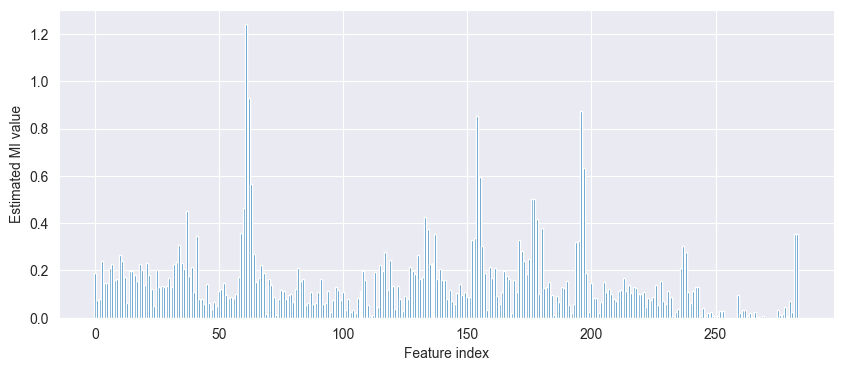

In [7]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated MI value')
plt.show()

In [8]:
f_selector = SelectKBest(score_func=mutual_info_regression, k=20)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

In [9]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import optuna

# objective function to be minimized.
def objective_fun(trial):

    n_estimators = trial.suggest_int('n_estimators', 20, 150)
    loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber'])
    subsample = trial.suggest_float('subsample', 0, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0, 0.5)
    max_depth = trial.suggest_int('max_depth', 1, 20)

    regressor_obj = GradientBoostingRegressor(n_estimators=n_estimators, loss=loss, subsample=subsample, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, criterion=criterion,  min_weight_fraction_leaf=min_weight_fraction_leaf, max_depth=max_depth)

    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_test)

    error = mean_squared_error(y_test, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=100)

[I 2023-06-01 16:32:33,803] A new study created in memory with name: no-name-6db29326-9ccc-4600-b917-8ec0f75e2a76
[I 2023-06-01 16:32:33,989] Trial 0 finished with value: 0.1008126180467204 and parameters: {'n_estimators': 109, 'loss': 'huber', 'subsample': 0.19458010207140752, 'min_samples_split': 11, 'min_samples_leaf': 15, 'criterion': 'squared_error', 'min_weight_fraction_leaf': 0.03283775295642938, 'max_depth': 4}. Best is trial 0 with value: 0.1008126180467204.
[I 2023-06-01 16:32:34,219] Trial 1 finished with value: 0.10903535675926725 and parameters: {'n_estimators': 149, 'loss': 'squared_error', 'subsample': 0.4291174252100479, 'min_samples_split': 3, 'min_samples_leaf': 11, 'criterion': 'friedman_mse', 'min_weight_fraction_leaf': 0.14865748474845297, 'max_depth': 17}. Best is trial 0 with value: 0.1008126180467204.
[I 2023-06-01 16:32:34,316] Trial 2 finished with value: 0.10453783812650984 and parameters: {'n_estimators': 131, 'loss': 'squared_error', 'subsample': 0.26242985

In [11]:
best_params = study.best_params

gb = GradientBoostingRegressor(**best_params)
gb.fit(X_train, y_train)

y_pred_test = gb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'n_estimators': 26, 'loss': 'squared_error', 'subsample': 0.6561350547103627, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'friedman_mse', 'min_weight_fraction_leaf': 0.0025671308677923145, 'max_depth': 12}
Root mean squared error = 0.2819
R-squared = 0.8260


In [12]:
y_pred = gb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([1.28207917e-02, 1.43299684e-03, 2.56657547e-02, ...,
       6.94912708e-05, 7.63208597e-05, 6.92705498e-05])

In [13]:
# negative values predicted
np.count_nonzero(y_pred < 0)

0

In [14]:
df_zero['stft_min'] = y_pred
df.update(df_zero)

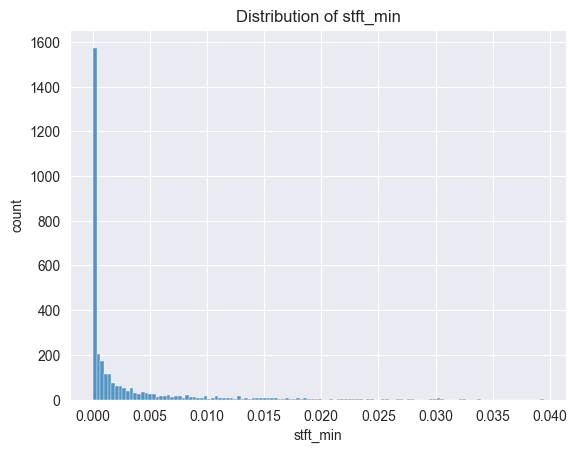

In [15]:
sns.histplot(data=df, x='stft_min', stat='density')
plt.xlabel(f'stft_min')
plt.ylabel('count')
plt.title(f'Distribution of stft_min')
plt.show()

In [17]:
df['stft_min'].corr(df['stft_q01'], method='spearman')

0.9332440261425395